<a href="https://colab.research.google.com/github/anushkamohan18/Fertiliser-Recommendation-System-for-Smart-Agriculture/blob/main/fertiliser_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openpyxl

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_excel("IOT_soil_fully_updated.xlsx")

# Display first few rows
print("Sample data:")
print(df.head())

# Encode fertilizer names into numbers for training (label encoding)
fertilizer_labels = df['Fertilizer Name'].unique()
label_to_number = {name: idx for idx, name in enumerate(fertilizer_labels)}
number_to_label = {idx: name for name, idx in label_to_number.items()}

# Apply the encoding
df['Label'] = df['Fertilizer Name'].map(label_to_number)

# Split features and labels
X = df.drop(columns=['Fertilizer Name', 'Label']).values
y = df['Label'].values

print("\nFeature shape:", X.shape)
print("Labels:", np.unique(y))


Sample data:
   Temparature  Humidity     Ph  Nitrogen  Potassium  Phosphorous  \
0           35     109.7  19.19        67        883         2356   
1           35     109.7  16.43        74        725         2356   
2           35     109.7  16.23        65        714         2357   
3           35     109.7  16.26        56        715         2356   
4           35     109.7  15.57        39        700         2355   

  Fertilizer Name  
0        17-17-17  
1           20-20  
2        10-26-26  
3        14-35-14  
4        14-35-14  

Feature shape: (8000, 6)
Labels: [0 1 2 3 4 5 6]


In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # only for leaf

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feat, best_thresh = self._best_split(X, y, num_features)

        if best_feat is None:
            return Node(value=self._most_common_label(y))

        left_idx = X[:, best_feat] < best_thresh
        right_idx = X[:, best_feat] >= best_thresh

        # 🔐 Important fix: handle case where a split is empty
        if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
            return Node(value=self._most_common_label(y))

        left = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, num_features):
        best_gain = -1
        split_idx, split_thresh = None, None

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                gain = self._information_gain(y, X[:, feature], t)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature
                    split_thresh = t

        return split_idx, split_thresh

    def _information_gain(self, y, feature_column, threshold):
        parent_loss = self._gini(y)

        left_idx = feature_column < threshold
        right_idx = feature_column >= threshold

        if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
            return 0

        n = len(y)
        n_left, n_right = len(y[left_idx]), len(y[right_idx])
        e_left, e_right = self._gini(y[left_idx]), self._gini(y[right_idx])
        child_loss = (n_left / n) * e_left + (n_right / n) * e_right

        return parent_loss - child_loss

    def _gini(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return 1 - np.sum(probs ** 2)

    def _most_common_label(self, y):
        if len(y) == 0:
            return 0  # Safe fallback if no data
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] < node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Split data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Create and train the Decision Tree
tree = DecisionTree(max_depth=10, min_samples_split=5)
tree.fit(X_train, y_train)

# Step 3: Predict on the test data
y_pred = tree.predict(X_test)

# Step 4: Evaluate the model
acc = accuracy_score(y_test, y_pred)
print(f"🌱 Custom Decision Tree Accuracy: {acc * 100:.2f}%")

# Optional: Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


🌱 Custom Decision Tree Accuracy: 14.31%

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.08      0.10       225
           1       0.00      0.00      0.00       221
           2       0.16      0.17      0.17       226
           3       0.14      0.14      0.14       237
           4       0.14      0.30      0.19       233
           5       0.14      0.22      0.17       224
           6       0.15      0.08      0.10       234

    accuracy                           0.14      1600
   macro avg       0.12      0.14      0.12      1600
weighted avg       0.13      0.14      0.13      1600

Confusion Matrix:
[[18  0 34 32 77 46 18]
 [15  0 33 33 68 55 17]
 [20  0 39 35 70 47 15]
 [12  0 24 34 84 59 24]
 [20  0 32 35 71 60 15]
 [18  0 36 37 67 49 17]
 [17  0 39 36 80 44 18]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
class DecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.feature_weights = {
            0: 1.0,  # Temperature
            1: 1.0,  # Humidity
            2: 1.5,  # Ph (most important)
            3: 1.4,  # Nitrogen
            4: 1.3,  # Potassium
            5: 1.4   # Phosphorous
        }

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feat, best_thresh = self._best_split(X, y, num_features)

        if best_feat is None:
            return Node(value=self._most_common_label(y))

        left_idx = X[:, best_feat] < best_thresh
        right_idx = X[:, best_feat] >= best_thresh

        if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
            return Node(value=self._most_common_label(y))

        left = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, num_features):
        best_gain = -1
        split_idx, split_thresh = None, None

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                gain = self._information_gain(y, X[:, feature], t)
                weighted_gain = gain * self.feature_weights.get(feature, 1.0)

                if weighted_gain > best_gain:
                    best_gain = weighted_gain
                    split_idx = feature
                    split_thresh = t

        return split_idx, split_thresh

    def _information_gain(self, y, feature_column, threshold):
        parent_loss = self._gini(y)
        left_idx = feature_column < threshold
        right_idx = feature_column >= threshold

        if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
            return 0

        n = len(y)
        n_left, n_right = len(y[left_idx]), len(y[right_idx])
        e_left, e_right = self._gini(y[left_idx]), self._gini(y[right_idx])
        child_loss = (n_left / n) * e_left + (n_right / n) * e_right

        return parent_loss - child_loss

    def _gini(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return 1 - np.sum(probs ** 2)

    def _most_common_label(self, y):
        if len(y) == 0:
            return 0
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] < node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [ ]:
forest = RandomForest(n_trees=30, max_depth=15, min_samples_split=5)
forest.fit(X_train, y_train)

y_pred_forest = forest.predict(X_test)
acc_forest = accuracy_score(y_test, y_pred_forest)
print(f"🌳 Improved Random Forest Accuracy: {acc_forest * 100:.2f}%")


🌳 Improved Random Forest Accuracy: 14.06%


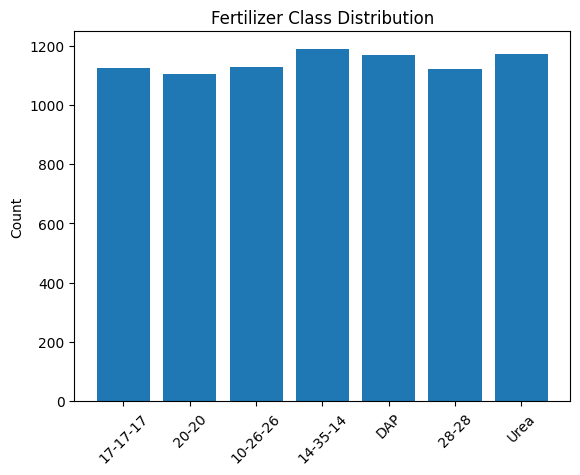

In [ ]:
import matplotlib.pyplot as plt

classes, counts = np.unique(y, return_counts=True)
plt.bar([number_to_label[c] for c in classes], counts)
plt.xticks(rotation=45)
plt.title("Fertilizer Class Distribution")
plt.ylabel("Count")
plt.show()


In [ ]:
!pip install lightgbm


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Split data again for LightGBM
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create LightGBM dataset
train_data = lgb.Dataset(X_train_lgb, label=y_train_lgb)
test_data = lgb.Dataset(X_test_lgb, label=y_test_lgb, reference=train_data)

# Train LightGBM model
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),  # Number of fertilizer classes
    'metric': 'multi_logloss',
    'verbosity': -1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1
}

lgb_model = lgb.train(params, train_data, num_boost_round=100)

# Predict
y_pred_lgb = lgb_model.predict(X_test_lgb)
y_pred_lgb_classes = np.argmax(y_pred_lgb, axis=1)

# Evaluate
acc_lgb = accuracy_score(y_test_lgb, y_pred_lgb_classes)
print(f"🌟 LightGBM Accuracy: {acc_lgb * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test_lgb, y_pred_lgb_classes))


🌟 LightGBM Accuracy: 14.31%

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.08      0.10       225
           1       0.00      0.00      0.00       221
           2       0.16      0.17      0.17       226
           3       0.14      0.14      0.14       237
           4       0.14      0.30      0.19       233
           5       0.14      0.22      0.17       224
           6       0.15      0.08      0.10       234

    accuracy                           0.14      1600
   macro avg       0.12      0.14      0.12      1600
weighted avg       0.13      0.14      0.13      1600



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


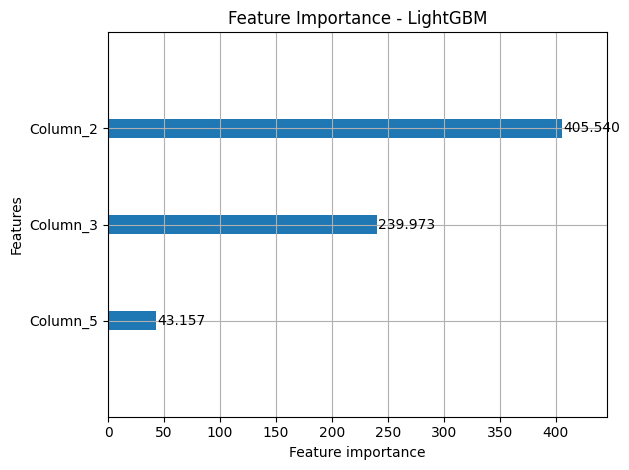

In [ ]:
# Plot feature importances
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='gain')
plt.title("Feature Importance - LightGBM")
plt.tight_layout()
plt.show()


In [ ]:
# Feature Engineering
df['NPK_Ratio'] = (df['Nitrogen'] + df['Potassium'] + df['Phosphorous']) / 3
df['Acid_Level'] = np.where(df['Ph'] < 7, 7 - df['Ph'], 0)  # Acidity if pH < 7
df['Combined_Index'] = df['Ph'] * df['NPK_Ratio'] / (df['Humidity'] + 1)

# Rebuild feature matrix with new columns
X_fe = df[['Temparature', 'Humidity', 'Ph', 'Nitrogen', 'Potassium', 'Phosphorous',
           'NPK_Ratio', 'Acid_Level', 'Combined_Index']].values
y_fe = df['Label'].values


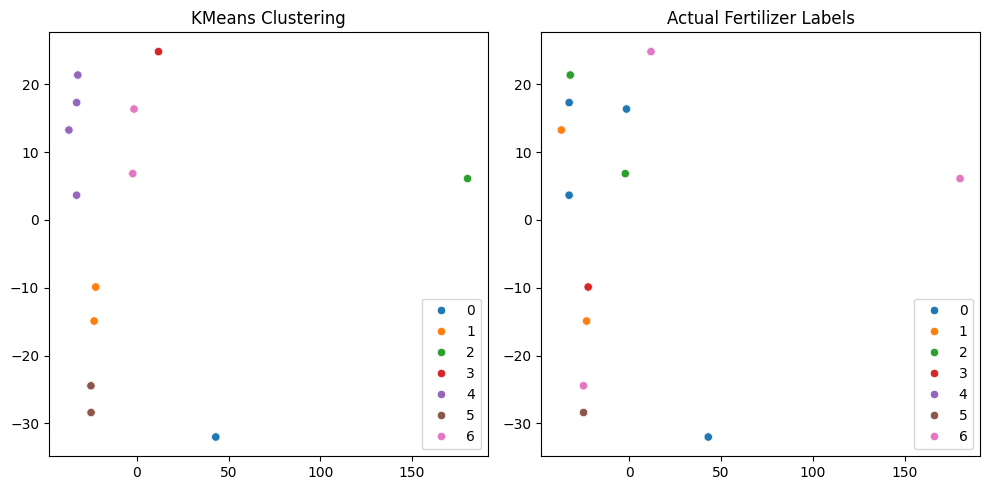

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_fe)

# Apply KMeans with 7 clusters (same as number of fertilizers)
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(X_fe)

# Plot clusters vs actual classes
plt.figure(figsize=(10, 5))

# Left: KMeans clusters
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='tab10')
plt.title("KMeans Clustering")

# Right: True labels
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_fe, palette='tab10')
plt.title("Actual Fertilizer Labels")
plt.tight_layout()
plt.show()


In [ ]:
!pip install xgboost


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_fe, y_fe, test_size=0.2, stratify=y_fe, random_state=42)

model_xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=7, eval_metric='mlogloss', use_label_encoder=False)
model_xgb.fit(X_train_xgb, y_train_xgb)

y_pred_xgb = model_xgb.predict(X_test_xgb)

acc_xgb = accuracy_score(y_test_xgb, y_pred_xgb)
print(f"🚀 XGBoost Accuracy on Engineered Features: {acc_xgb * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test_xgb, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:59:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🚀 XGBoost Accuracy on Engineered Features: 14.31%

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.08      0.10       225
           1       0.00      0.00      0.00       221
           2       0.16      0.17      0.17       226
           3       0.14      0.14      0.14       237
           4       0.14      0.30      0.19       233
           5       0.14      0.22      0.17       224
           6       0.15      0.08      0.10       234

    accuracy                           0.14      1600
   macro avg       0.12      0.14      0.12      1600
weighted avg       0.13      0.14      0.13      1600



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


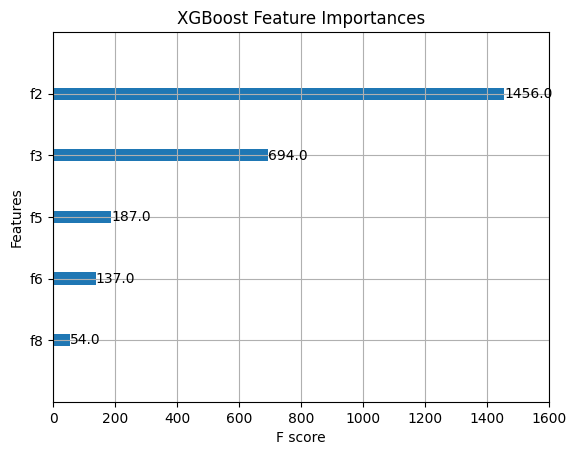

In [ ]:
xgb.plot_importance(model_xgb)
plt.title("XGBoost Feature Importances")
plt.show()
